# DS 3001 Project Part 3: 
## Results - Fraud Detection Analysis
#### Goal: Analyze transaction-level data in order to understand the patterns that distinguish fraudulent transactions from legitimate ones and to build a model that can accurately predict fraud before it occurs

##### Prediction Question
The central prediction question of this study is "Can transaction data accurately distinguish fraudulent transactions from legitimate ones and what patterns direct this distinction?" This question is rooted in a practical concern shared by financial institutions and digital payment platforms as there is the need to detect fraud in real time using readily available transaction features, without relying on personally identifiable information. My goal was to construct a supervised machine learning model capable of making high-precision fraud predictions based on historical transaction characteristics.


##### Key Findings and Visualizations
To address this question, I trained and tested three classification models, Logistic Regression, Decision Tree, and Random Forest, using a labeled dataset of synthetic transaction records. Each transaction was classified as either fraudulent or not, based on attributes such as transaction amount, frequency, card age, and device type.  All models were evaluated on a hold-out test set, using F1 score, precision, recall, and accuracy as performance metrics. The Random Forest classifier achieved the best overall performance with the key metrics summarized in the table below.



In [21]:
print(comparison_df)

                     F1 Score  Precision   Recall  Accuracy
Logistic Regression  0.738713   0.754594  0.73224   0.73224
Decision Tree        0.802992   0.801932  0.80496   0.80496
Random Forest        0.867413   0.895787  0.87688   0.87688


**Confusion Matrix**


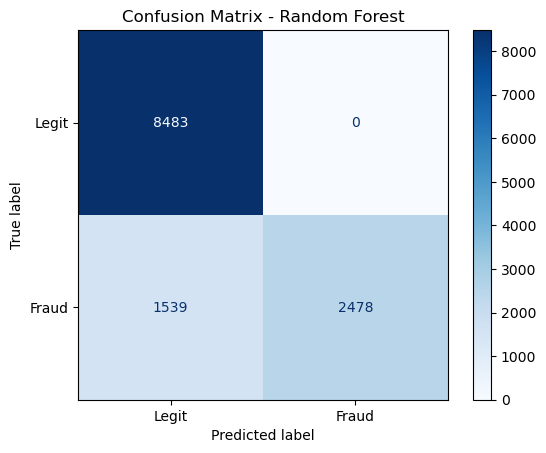

In [14]:
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()

The confusion matrix provides a breakdown of the model’s predictions for each class. Out of 12,500 transactions, the model:
- Correctly identified 8,483 legitimate transactions (true negatives)
- Correctly identified 2,478 fraudulent transactions (true positives)
- Incorrectly classified 1,539 fraud cases as legitimate (false negatives)
- Made no false positives, meaning it did not mislabel any legitimate transactions as fraud

This distribution indicates a conservative model that prioritizes precision over recall. While it rarely flags legitimate transactions incorrectly, it misses a significant number of fraud cases, which could be problematic in high-risk financial environments.

**Precision-Recall Curve** 


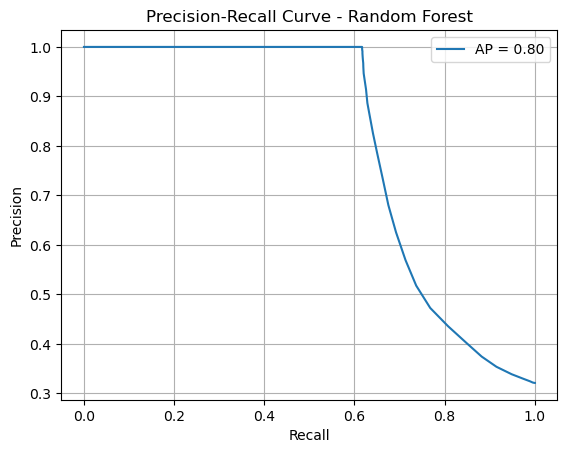

In [15]:
plt.plot(recall, precision, label=f"AP = {ap_score:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Random Forest")
plt.legend()
plt.grid()
plt.show()


The precision-recall curve shows how well the model balances catching fraud (recall) against raising false alarms (precision). The curve begins with high precision (~1.0) at low recall and declines as recall increases. The average precision (AP) is 0.80, which reflects the model's solid ability to identify fraud while maintaining low false-positive rates.

This behavior is typical of models trained on imbalanced datasets, where one class (legitimate) dominates. The shape of the curve indicates that, although the model performs well, pushing for higher recall leads to sharp drops in precision, a common trade-off in fraud detection.

**ROC Curve**


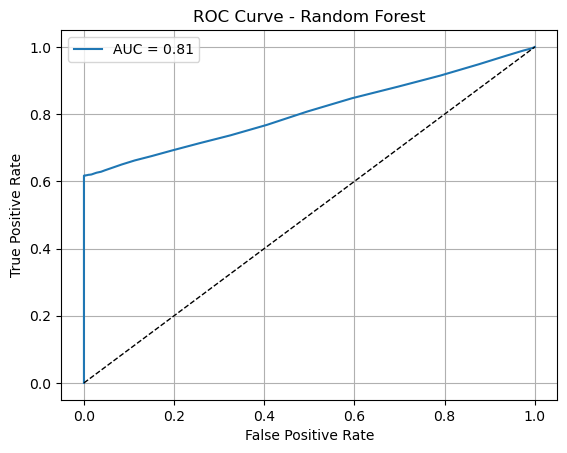

In [13]:
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid()
plt.show()


The ROC curve plots the true positive rate against the false positive rate. The model achieves an AUC (Area Under Curve) of 0.81, which indicates strong discriminatory ability between the fraud and legitimate classes. The curve rises quickly, showing that the model can identify a large portion of fraud cases with only a small number of false positives.

However, the middle section of the curve flattens, suggesting diminishing returns in fraud detection as the false positive rate increases. While the model is effective overall, it still leaves room for improvement, particularly in sensitivity.

##### Feature Importance
An inspection of the Random Forest model’s feature importances highlights the overwhelming influence of behavioral transaction patterns over categorical identifiers in predicting fraud. The most predictive feature, by a wide margin, was Failed_Transaction_Count_7d, contributing over 35% of the model’s decision-making power. This suggests that a recent spike in failed transaction attempts is a strong behavioral signal of fraud, likely capturing patterns of malicious probing behavior that precedes successful unauthorized access.

Other notable but far less dominant predictors include Transaction_Distance, Avg_Transaction_Amount_7d, and Account_Balance, each contributing roughly 1% of total model importance. These features collectively reflect contextual anomalies in spending, such as unusual geographic distance from previous transaction locations, high average spend over recent history, or low account balances preceding fraud events.

In contrast, categorical variables—such as card type, device type, authentication method, and merchant category—each carried very low individual importance scores (typically below 0.2%). This suggests that while categorical descriptors may provide some marginal signal, they are far less informative than temporal and quantitative behavior patterns.


In [11]:
print(feature_importance_df.head(20))

                                    Feature  Importance
6          num__Failed_Transaction_Count_7d    0.351892
8                 num__Transaction_Distance    0.011586
5            num__Avg_Transaction_Amount_7d    0.011554
1                      num__Account_Balance    0.011396
0                   num__Transaction_Amount    0.011336
7                             num__Card_Age    0.010696
4              num__Daily_Transaction_Count    0.007744
9                           num__Is_Weekend    0.002336
82545               cat__Device_Type_Mobile    0.002010
82544               cat__Device_Type_Laptop    0.001983
82564   cat__Authentication_Method_Password    0.001959
82557                   cat__Card_Type_Amex    0.001958
82563        cat__Authentication_Method_PIN    0.001927
82546               cat__Device_Type_Tablet    0.001910
82559             cat__Card_Type_Mastercard    0.001896
82560                   cat__Card_Type_Visa    0.001882
82561  cat__Authentication_Method_Biometric    0

##### Interpretation and Discussion

The results demonstrate that supervised machine learning methods can accurately detect fraudulent transactions using behavioral and contextual features, without relying on direct identifiers. The success of the Random Forest model highlights the importance of ensemble learning techniques in capturing non-linear relationships and interactions.

While promising, the synthetic nature of the dataset may limit generalizability. The strong performance may partially reflect artificial separability between classes. Additionally, some top features (Failed_Transaction_Count_7d) may not always be available in real-time, or may themselves be partially informed by post-labeling. Further analysis with live, real-world data would be necessary to validate the model in a production setting.

While certain features are highly predictive in this model, this does not imply a causal relationship. For example, a higher transaction distance may correlate with fraud risk in the dataset, but does not cause fraud in any deterministic sense. This model is best viewed as a statistical tool for risk scoring rather than a definitive fraud classifier.


### Appendix: Results Code

In [ ]:
# All Imports
import pandas as pd
import numpy as np
import kagglehub
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

path = kagglehub.dataset_download("samayashar/fraud-detection-transactions-dataset")
print("Path to dataset files:", path)

csv_path = f"{path}/synthetic_fraud_dataset.csv" 
df = pd.read_csv(csv_path)

X = df.drop(columns='Fraud_Label') 
X = X.drop(columns=['Risk_Score'])
y = df['Fraud_Label']               

Path to dataset files: C:\Users\puckh\.cache\kagglehub\datasets\samayashar\fraud-detection-transactions-dataset\versions\1


In [3]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Numeric data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)


In [5]:
# Logistic Regression 
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# Decision Tree 
tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=42))
])

# Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])


In [6]:
def evaluate_model(pipeline, model_name):
    print(f"--- {model_name} ---")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    print(classification_report(y_test, y_pred, digits=4))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    print("\n")


evaluate_model(logreg_pipeline, "Logistic Regression")
evaluate_model(tree_pipeline, "Decision Tree")
evaluate_model(rf_pipeline, "Random Forest")

--- Logistic Regression ---
              precision    recall  f1-score   support

           0     0.8436    0.7433    0.7902      8483
           1     0.5667    0.7090    0.6299      4017

    accuracy                         0.7322     12500
   macro avg     0.7051    0.7261    0.7101     12500
weighted avg     0.7546    0.7322    0.7387     12500

Confusion Matrix:
[[6305 2178]
 [1169 2848]]


--- Decision Tree ---
              precision    recall  f1-score   support

           0     0.8448    0.8730    0.8587      8483
           1     0.7115    0.6612    0.6854      4017

    accuracy                         0.8050     12500
   macro avg     0.7781    0.7671    0.7720     12500
weighted avg     0.8019    0.8050    0.8030     12500

Confusion Matrix:
[[7406 1077]
 [1361 2656]]


--- Random Forest ---
              precision    recall  f1-score   support

           0     0.8464    1.0000    0.9168      8483
           1     1.0000    0.6169    0.7630      4017

    accuracy    

In [7]:
models = {
    "Logistic Regression": logreg_pipeline,
    "Decision Tree": tree_pipeline,
    "Random Forest": rf_pipeline
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    results[name] = {
        "F1 Score": report['weighted avg']['f1-score'],
        "Precision": report['weighted avg']['precision'],
        "Recall": report['weighted avg']['recall'],
        "Accuracy": report['accuracy']
    }

comparison_df = pd.DataFrame(results).T
print(comparison_df)

                     F1 Score  Precision   Recall  Accuracy
Logistic Regression  0.738713   0.754594  0.73224   0.73224
Decision Tree        0.802992   0.801932  0.80496   0.80496
Random Forest        0.867413   0.895787  0.87688   0.87688


In [8]:
importances = rf_pipeline.named_steps['classifier'].feature_importances_
feature_names = rf_pipeline.named_steps['preprocessor'].get_feature_names_out()

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df.head(20))

                                    Feature  Importance
6          num__Failed_Transaction_Count_7d    0.351892
8                 num__Transaction_Distance    0.011586
5            num__Avg_Transaction_Amount_7d    0.011554
1                      num__Account_Balance    0.011396
0                   num__Transaction_Amount    0.011336
7                             num__Card_Age    0.010696
4              num__Daily_Transaction_Count    0.007744
9                           num__Is_Weekend    0.002336
82545               cat__Device_Type_Mobile    0.002010
82544               cat__Device_Type_Laptop    0.001983
82564   cat__Authentication_Method_Password    0.001959
82557                   cat__Card_Type_Amex    0.001958
82563        cat__Authentication_Method_PIN    0.001927
82546               cat__Device_Type_Tablet    0.001910
82559             cat__Card_Type_Mastercard    0.001896
82560                   cat__Card_Type_Visa    0.001882
82561  cat__Authentication_Method_Biometric    0

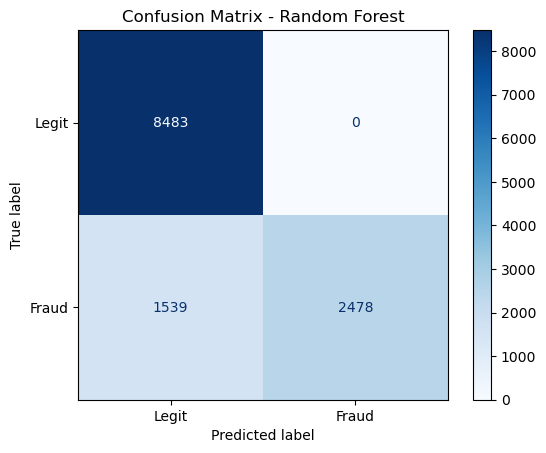

In [9]:
y_pred_rf = rf_pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legit", "Fraud"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()

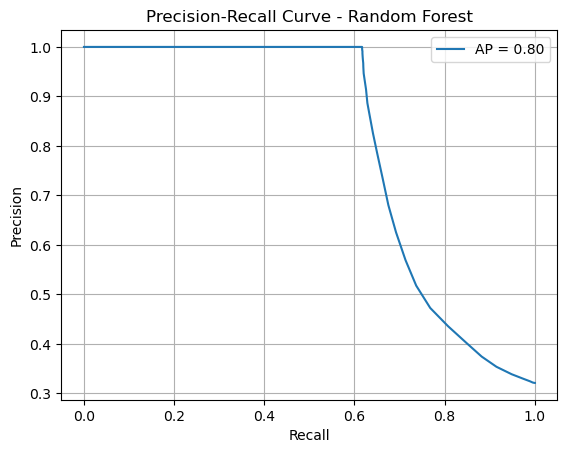

In [10]:
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_proba_rf)
ap_score = average_precision_score(y_test, y_proba_rf)

plt.plot(recall, precision, label=f"AP = {ap_score:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Random Forest")
plt.legend()
plt.grid()
plt.show()

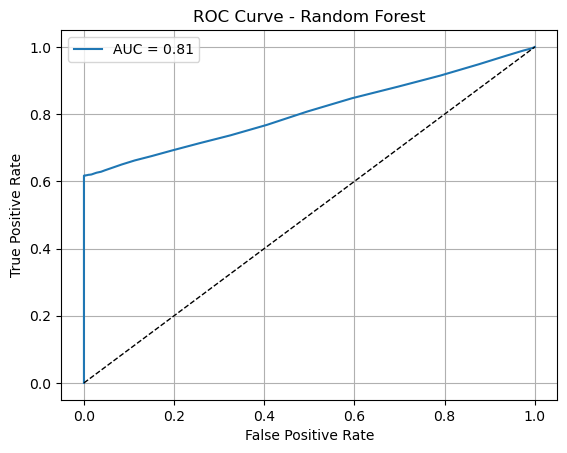

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid()
plt.show()
